<a href="https://colab.research.google.com/github/emmarant/ML_NIAG/blob/master/ML_NIAG_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


06/04/2020
Second attempt for a model that differentiates between different energy events.
This is the difference to the original model: somehow, the original model started complaining about the size of the images (650x650px), although for some time it was running successfuly. I am now using images of smaller initial size (325x325px) which I acquire by spliting each original image to 16 new images. This preprossesing is done outside this notebook. The new images are in png format. So now for each wavelength I have 2000x16 images. Let's see how this will fare. Also, I will now be using the full size of the images (325x325). In the previous version i was downsizing from 1300x1300 to 650x650 with the ImageDataGenerator.


---





---


####Install and import usefull stuff


---



In [ ]:
! pip install neptune-client

In [ ]:
!pip install tensorflow-gpu==2.0.0

In [ ]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import os, shutil
from shutil import copyfile
import random

print(keras.__version__)
print(tensorflow.__version__)

2.3.0-tf
2.2.0


### Import DATA

#### 1) Import data from google drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!cp /content/drive/'My Drive'/niag_data/ML_NIAG_data.zip /content

In [ ]:
#!unzip /content/ML_NIAG_data.zip

In [ ]:
#!rm /content/ML_NIAG_data.zip


#### *2) Or import data from local drive* (this doesn't seem to work at the moment)




In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
!unzip /content/Archive.zip

In [ ]:
!rm /content/Archive.zip

#### 3) Or import data from Dropbox

either clone the relevant .sh file from the following git repo, or google drive upload it from my drive (i've kept a copy there in case the git repo is not available anymore)

I have created an App in Dropbox with a relevant dir (App/ColabFileUploader). Files stored in that folder can be coppied over to colab. A token generated by that app is needed as seen below.

The process is described in this [website](https://www.freecodecamp.org/news/how-to-transfer-large-files-to-google-colab-and-remote-jupyter-notebooks-26ca252892fa/)

In [ ]:
!git clone https://github.com/thatbrguy/Dropbox-Uploader.git

In [ ]:
cd Dropbox-Uploader

/content/Dropbox-Uploader


In [ ]:
!chmod +x dropbox_uploader.sh

In [ ]:
!bash dropbox_uploader.sh


 This is the first time you run this script, please follow the instructions:

 1) Open the following URL in your Browser, and log in using your account: https://www.dropbox.com/developers/apps
 2) Click on "Create App", then select "Dropbox API app"
 3) Now go on with the configuration, choosing the app permissions and access restrictions to your DropBox folder
 4) Enter the "App Name" that you prefer (e.g. MyUploader236372771322293)

 Now, click on the "Create App" button.

 When your new App is successfully created, please click on the Generate button
 under the 'Generated access token' section, then execute the following command:

 echo "INPUT_YOUR_ACCESS_TOKEN_HERE" > token.txt



In [ ]:
!echo 'h5uI6t9SsgkAAAAAAAALZbkXkgeR-lB6VYTn4i7RcqoCd_sbIcjCzPbnf9pWF7o0' > token.txt


In [ ]:
!bash dropbox_uploader.sh download processed_images.tgz /content

 > Downloading "/processed_images.tgz" to "/content/processed_images.tgz"... DONE


In [ ]:
! tar -xzvf /content/processed_images.tgz

In [ ]:
!rm /content/processed_images.tgz

#### 4) More direct way to get data from Dropbox




In [ ]:
! wget https://www.dropbox.com/s/8sex0m0trslovok/processed_images.tgz?dl=0

In [ ]:
!tar -xzvf processed_images.tgz

### Create dir structure to place the data, populate it with data and check structure and number of files in each subdir

In [ ]:
# create the hierarchy of directories to copy the data into

class_data_path='/content/lambda_classification_data'
if not os.path.exists(class_data_path):
  os.mkdir(class_data_path)

data_types=['train','validation','test']
classes=[2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0]


for dtype in data_types:
  for i in classes:
    suffix='AA'
    directory=str(i)+suffix
    path1='/content/lambda_classification_data'
    path2=dtype
    path3=os.path.join(path1,path2)
    if not os.path.exists(path3):
      os.mkdir(path3)
    path=os.path.join(path3,directory)
    if not os.path.exists(path):
      os.mkdir(path)      




In [ ]:
# function for splitting the data into train, validation, and test data (after shuffling them) and populating the directoyr structure created above

def pop_dirs(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    validation_length = int((len(files) - training_length)/10.0)
    test_length = validation_length
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:training_length+validation_length]
    test_set = shuffled_set[training_length+validation_length:training_length+validation_length+test_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)
        os.remove(this_file)

    for filename in validation_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)
        os.remove(this_file)

    for filename in test_set:
        this_file = SOURCE + filename
        destination = TEST + filename
        copyfile(this_file, destination)
        os.remove(this_file)




In [ ]:
# the actual copying of files from the 'data' folder into the local labeled folder structure 
src_classes=['2p5','3p0','3p5','4p0','4p5','5p0','5p5','6p0']
dest_classes=[2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0]
j=0
split_size = .35
for i in src_classes:
  directory=str(i)+'AA_split'
  
  dest_directory=str(dest_classes[j])+'AA'
  src_dir="/content/processed_images/"
  src_path=os.path.join(src_dir,directory)+'/'
  
  training_dir = "/content/lambda_classification_data/train"
  train_path=os.path.join(training_dir,dest_directory)+'/'
  
  validation_dir = "/content/lambda_classification_data/validation"
  validation_path=os.path.join(validation_dir,dest_directory)+'/'

  test_dir = "/content/lambda_classification_data/test"
  test_path=os.path.join(test_dir,dest_directory)+'/'

  pop_dirs(src_path, train_path, validation_path, test_path, split_size)

  
  print(src_path)
  j+=1


/content/processed_images/2p5AA_split/
/content/processed_images/3p0AA_split/
/content/processed_images/3p5AA_split/
/content/processed_images/4p0AA_split/
/content/processed_images/4p5AA_split/
/content/processed_images/5p0AA_split/
/content/processed_images/5p5AA_split/
/content/processed_images/6p0AA_split/


In [ ]:
# check number of images per directory

data_types=['train','validation','test']
classes=[2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0]


for dtype in data_types:
  for c in classes:
    path=os.path.join('/content/lambda_classification_data',dtype,str(c)+'AA')
    print('number of',  dtype,  'images in', str(c),':', len(os.listdir(path)))


number of train images in 2.5 : 11200
number of train images in 3.0 : 11200
number of train images in 3.5 : 11200
number of train images in 4.0 : 11200
number of train images in 4.5 : 11200
number of train images in 5.0 : 11200
number of train images in 5.5 : 11200
number of train images in 6.0 : 11200
number of validation images in 2.5 : 2080
number of validation images in 3.0 : 2080
number of validation images in 3.5 : 2080
number of validation images in 4.0 : 2080
number of validation images in 4.5 : 2080
number of validation images in 5.0 : 2080
number of validation images in 5.5 : 2080
number of validation images in 6.0 : 2080
number of test images in 2.5 : 2080
number of test images in 3.0 : 2080
number of test images in 3.5 : 2080
number of test images in 4.0 : 2080
number of test images in 4.5 : 2080
number of test images in 5.0 : 2080
number of test images in 5.5 : 2080
number of test images in 6.0 : 2080


### Build and run the model


#### CASE 1
```
Simple sequential CNN 

```

In [ ]:
tensorflow.keras.backend.clear_session()

In [ ]:
# place needed and updatable parameters in a dictionary for easy access 
PARAMS = {'lr': 1e-4,
          'dropout': 0.0,
          'batch_size': 64,
          'n_epochs': 2,
          'optimizer': 'RMSprop',
          'loss': 'categorical_crossentropy',
          'metrics': 'acc',
          'activations': 'relu, softmax',
          'notebook':'/content/drive/My Drive/Colab Notebooks/ML_NIAG.ipynb',
          'image_input_shape' : (325,325,1),
          'data_description' : 'png, BW, 8 classes AA=[2.5,3.0,3.5,4.0,4.5,5.0,5.0,6.0]',
          'dataset size' : 'each one of all 8 classes have: [11200 tr], [2080 val], [2080 te]   ',
          'run_name' : 'simple_seq_multiclass_NIAG_v13',
          'save_model' : 'simple_seq_multiclass_NIAG_v13.h5',
          'run env' : 'google colab',
          'NOTES' :  'initial images split in 16 images each. pre-processing of images: remove mean and divide by std for each image seperately. No division with 255',
          'NOTES' :  'dropout to 0.0'
          }

In [ ]:
# the model layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(325,325,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Flatten())
#model.add(layers.Dropout(PARAMS['dropout']))
#model.add(layers.Dense(256, activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(8, activation='softmax'))

In [ ]:
# compile model (and choose optimiser )
model.compile(loss=PARAMS['loss'],
              optimizer=optimizers.RMSprop(lr=PARAMS['lr']),
              metrics=[PARAMS['metrics']])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 323, 323, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 161, 161, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 159, 159, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 79, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 256)       2

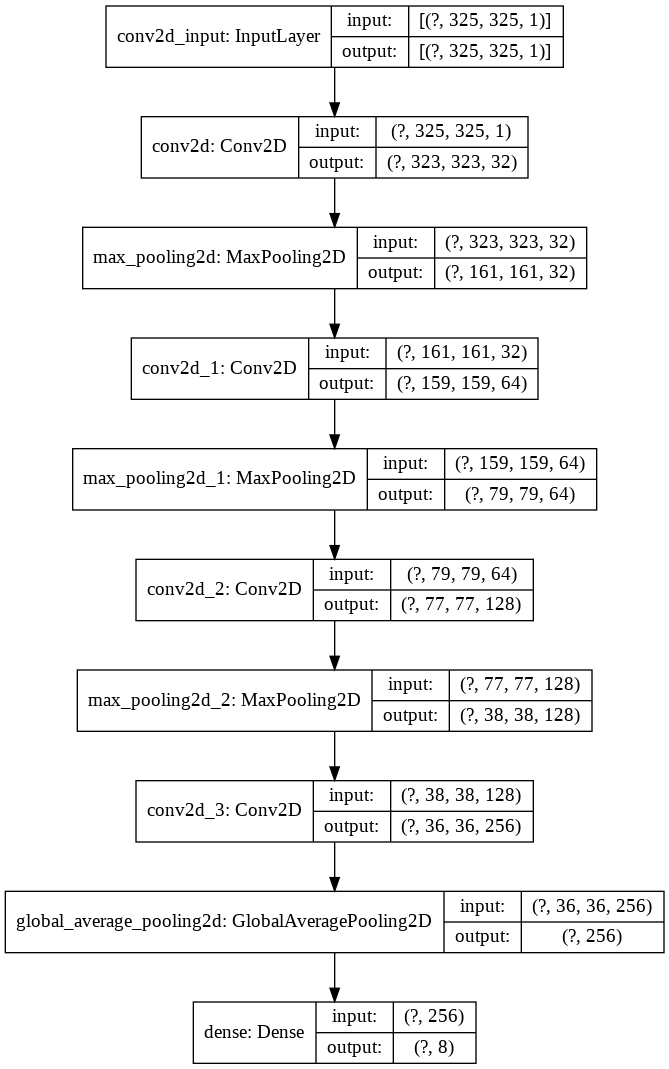

In [ ]:
# create a graph of the model layers
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB',show_layer_names=True)


In [ ]:
# NOTE: use color_mode="grayscale" below only when dealing with grayscale images. Otherwise 3 channel images are expected
train_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,ertial_flip=True)
validation_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
test_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)

train = train_datagen.flow_from_directory(
        '/content/lambda_classification_data/train',
        target_size=(325, 325),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical', color_mode="grayscale") 

validation = validation_datagen.flow_from_directory(
        '/content/lambda_classification_data/validation',
        target_size=(325, 325),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical', color_mode="grayscale")


test = test_datagen.flow_from_directory(
        '/content/lambda_classification_data/test',
        target_size=(325, 325),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical', color_mode="grayscale")

Found 89599 images belonging to 8 classes.
Found 16640 images belonging to 8 classes.
Found 16640 images belonging to 8 classes.


In [ ]:
for images_batch, labels_batch in train:
    print('Image batches have shape:', images_batch.shape)
    print('Lable batches have shape:', labels_batch.shape)
    break

Image batches have shape: (64, 325, 325, 1)
Lable batches have shape: (64, 8)


In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.0%
class EndCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True


In [ ]:
# Define a callback class for communicating with neptune
class NeptuneMonitorCallback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        neptune.send_metric('accuracy', epoch+1, logs['acc'])
        neptune.send_metric('loss', epoch+1, logs['loss'])
        neptune.send_metric('validation accuracy', epoch+1, logs['val_acc'])
        neptune.send_metric('validation loss', epoch+1, logs['val_loss'])

In [ ]:
from time import time
class TimingCallback(tensorflow.keras.callbacks.Callback):
  def __init__(self):
    self.logs=[]
  def on_epoch_begin(self,epoch, logs={}):
    self.starttime=time()
  def on_epoch_end(self,epoch, logs={}):
    self.logs.append(time()-self.starttime)



In [ ]:
% env NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiIyZGIwNDUyNS0zN2M4LTQ2NDItYTdiNS1mODBjYzJjNDFiMGUifQ=='

env: NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiIyZGIwNDUyNS0zN2M4LTQ2NDItYTdiNS1mODBjYzJjNDFiMGUifQ=='


In [ ]:
import neptune
neptune.init('emmarant/multiclass-NIAG-1')

Project(emmarant/multiclass-NIAG-1)

In [ ]:
# Fit the model and send relevant outputs to neptune

spe=len(train)   # train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size

## callbacks 
end_callback = EndCallback()
timing_callback = TimingCallback()
neptune_monitor = NeptuneMonitorCallback()



with neptune.create_experiment(name=PARAMS['run_name'],params=PARAMS):
  history = model.fit_generator(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps,
            callbacks=[end_callback,timing_callback,neptune_monitor]) 
  model.save(PARAMS['save_model'])
  neptune.send_artifact(PARAMS['save_model'])
  neptune.send_text('epoch training times',"".join(format(x, "10.5f") for x in timing_callback.logs))
  #neptune.send_artifact(PARAMS['notebook'])
  neptune.send_artifact('/content/model.png')

  metrics = model.metrics_names
  test_score = model.evaluate_generator(test, 50)
  neptune.set_property(metrics[0], str(test_score[0]))
  neptune.set_property(metrics[1], str(test_score[1]))

### Plotting

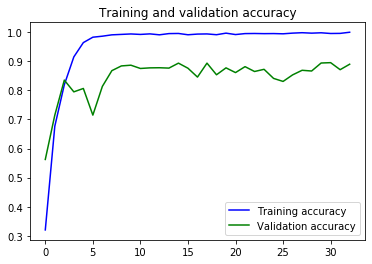

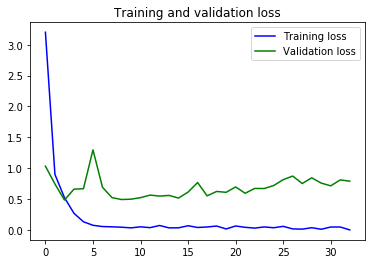

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model = load_model('simple_seq_multiclass_NIAG_v6.h5')
#epoch_num=PARAMS['n_epochs']
epoch_num=33
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [ ]:
test_score = model.evaluate_generator(test, 50)
print(model.metrics_names)
print(test_score)
print()
print("Accuracy = ",test_score[1]*100,'%')

['loss', 'acc']
[0.8114979001879692, 0.8986667]

Accuracy =  89.86666798591614 %


### Class Activation Maps


In [ ]:
modelCAM=tensorflow.keras.models.load_model('/content/simple_seq_multiclass_NIAG_v11.h5')

modelCAM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 323, 323, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 161, 161, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 159, 159, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 79, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 256)       2

In [ ]:
import scipy as sp
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.cm as cm


#### A

In [ ]:
idx=15
gap_weights=modelCAM.layers[-1].get_weights()[0]
gap_weights.shape
last_conv_layer=modelCAM.get_layer('conv2d_3')
class_layer=modelCAM.get_layer('dense_1')
cam_model=Model(inputs=modelCAM.input,outputs=(last_conv_layer.output,class_layer.output))
features,results=cam_model.predict(test[1])
print(features.shape)
print(results.shape)
pred=np.argmax(results[idx])
print(pred)

(64, 36, 36, 256)
(64, 8)
4


In [ ]:
cam_weights=gap_weights[:,pred]
cam_features=features[idx,:,:,:]
heatmap=np.dot(cam_features,cam_weights)

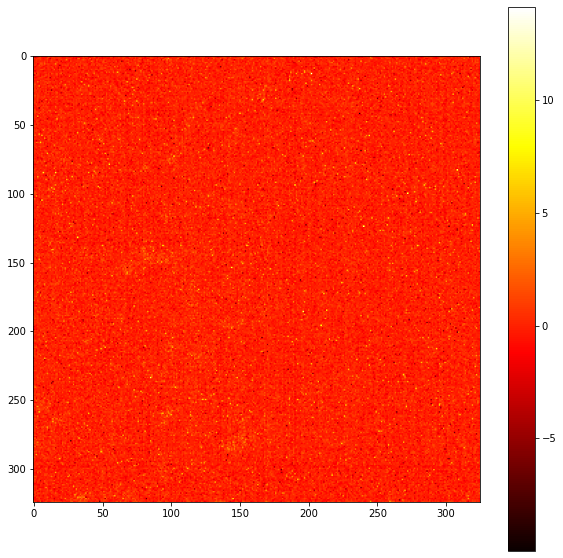

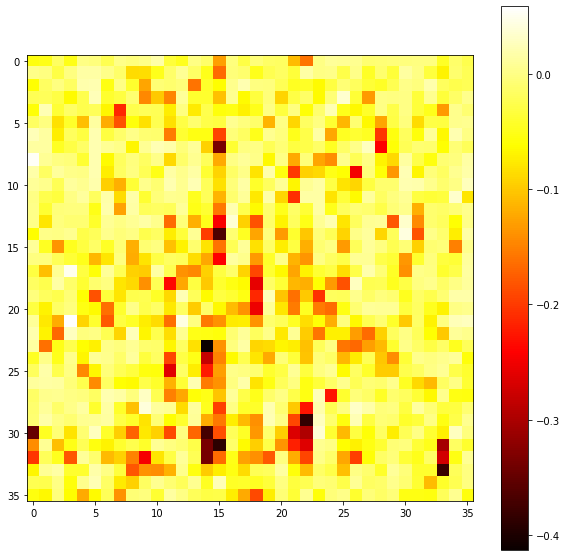

In [ ]:
color='hot'
fig1,ax1=plt.subplots(facecolor='white',figsize=(10,10))
pos1=ax1.imshow(np.squeeze(test[1][0][idx],-1),cmap=color)
fig1.colorbar(pos1, ax=ax1)
fig2,ax2=plt.subplots(facecolor='white',figsize=(10,10))
pos2=ax2.imshow(heatmap,cmap=color)
fig2.colorbar(pos2, ax=ax2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


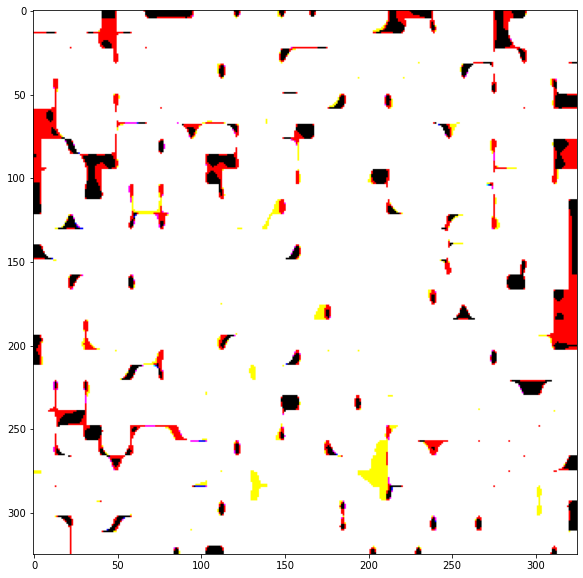

In [ ]:

# transform heatmap values range from 0 to 255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap(color)

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]


# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((325,325))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)


plt.figure(figsize=(10,10))
plt.imshow(jet_heatmap,cmap=color)

img=test[1][0][idx]

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "test_cam.jpg"
superimposed_img.save(save_path)


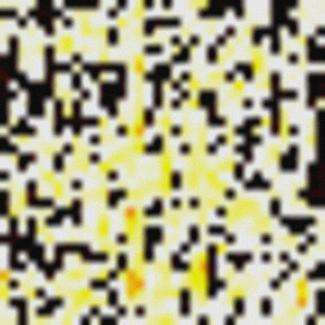

In [ ]:
display(Image(save_path,width=600,height=600,))

#### B. (this is not working and is also incomplete // should be erased)

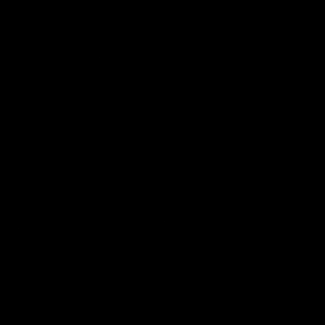

In [ ]:
preprocess_input = keras.applications.xception.preprocess_input

img_size = (325, 325)

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "dense",
    "dense_1",
]

# The local path to our target image
img_path = "/content/lambda_classification_data/test/2.5AA/3ms1_00011_04_01.png"

display(Image(img_path))


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
img_array = get_img_array(img_path, size=img_size)

print(img_array[:,:,:,0].shape)
# Make model


# Print what the top predicted class is
results = modelCAM.predict(np.expand_dims(img_array[:,:,:,0],axis=-1))
pred=np.argmax(results)

print("Predicted:", pred)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, modelCAM, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
#plt.matshow(heatmap)
#plt.show()

(1, 325, 325)
Predicted: 1


ValueError: ignored